In [1]:
# --- Standard imports ---
import os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy.stats import boxcox

from config_local import local_config  # provides TRAIN_CSV, TEST_CSV, SUBMISSIONS_DIR

In [2]:
def plot_transforms(df):
    cols = [
        ("SalePrice", "Original SalePrice"),
        ("logSP", "Log1p"),
        ("SquareRootSP", "Square Root"),
        ("BoxCoxSP", "Box-Cox"),
        ("YeoJohnsonSP", "Yeo-Johnson"),
        ("QuantileSP", "Quantile (Normal)")
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.ravel()
    
    for ax, (col, title) in zip(axes, cols):
        if col in df.columns:
            ax.hist(df[col], bins=40, edgecolor="k", alpha=0.7)
            ax.set_title(title)
            ax.set_xlabel(col)
            ax.set_ylabel('# of Houses')
            
    plt.tight_layout()
    plt.show()

In [3]:
train = pd.read_csv(local_config.TRAIN_PROCESS1_CSV)   # e.g. data/train_filled.csv         
test = pd.read_csv(local_config.TEST_PROCESS1_CSV)    # e.g. data/test_filled.csv

# Sale price transform and standardisation

In [4]:
salePriceReshape = train["SalePrice"].values.reshape(-1, 1)

salePrice_df = pd.DataFrame(columns = ['SalePrice', 'logSP', 'SquareRootSP', 'BoxCoxSP', 'YeoJohnsonSP', 'QuantileSP', 'QuantileSP'])
transforms = {
    "SalePrice": lambda x: x.ravel(),
    "logSP": lambda x: np.log1p(x).ravel(),
    "SquareRootSP": lambda x: np.sqrt(x).ravel(),
    "BoxCoxSP": lambda x: boxcox(x.ravel())[0],  # BoxCox returns (vals, lambda)
    "YeoJohnsonSP": lambda x: PowerTransformer(method="yeo-johnson").fit_transform(x).ravel(),
    "QuantileSP": lambda x: QuantileTransformer(output_distribution="normal", random_state=0).fit_transform(x).ravel()
}
salePrice_df = pd.DataFrame({name: func(salePriceReshape) for name, func in transforms.items()})
salePrice_df.head(3)

,SalePrice,logSP,SquareRootSP,BoxCoxSP,YeoJohnsonSP,QuantileSP
0,208500,12.247699,456.618002,7.932608,0.571155,0.624748
1,181500,12.109016,426.028168,7.878261,0.227627,0.311577
2,223500,12.317171,472.757866,7.959615,0.741869,0.764710


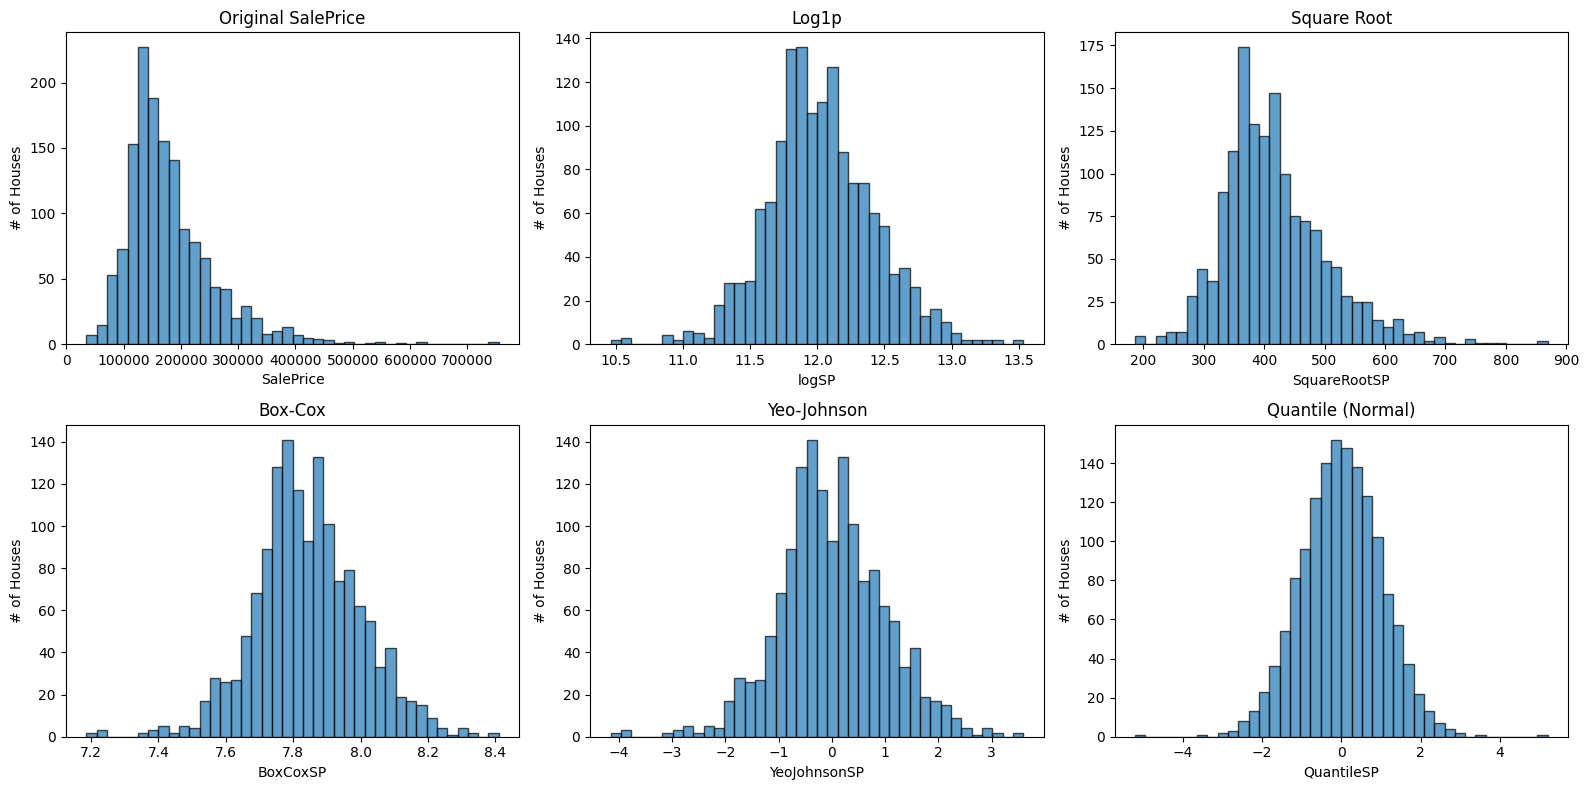

In [5]:
plot_transforms(salePrice_df)

# Outliers

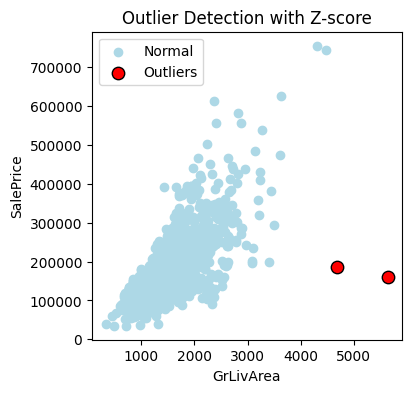

In [6]:
# Compute z-scores
z_scores = np.abs(stats.zscore(train["GrLivArea"]))
outlier_mask = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)#z_scores > 3  # mark outliers

# Plot all points in blue
plt.figure(figsize=(4,4))
plt.scatter(train["GrLivArea"], train["SalePrice"], c="lightblue", label="Normal")

# Overlay outliers in red
plt.scatter(train.loc[outlier_mask, "GrLivArea"], 
            train.loc[outlier_mask, "SalePrice"], 
            c="red", edgecolor="black", s=80, label="Outliers")

plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.legend()
plt.title("Outlier Detection with Z-score")
plt.show()

In [7]:
# # Drop rows where GrLivArea is very high and SalePrice is low
outlier_mask = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)
train = train.loc[~outlier_mask]

In [8]:

train["logSP"] = salePrice_df['logSP']

if "SalePrice" in train.columns:
    train = train.drop(columns=["SalePrice"])
    
salePrice_df.to_csv(__import__("pathlib").Path(local_config.SALEPRICE_TRANSFORMS_CSV).resolve().parent / "salePrice_transforms.csv", index=False)

In [9]:
train.to_csv(__import__("pathlib").Path(local_config.TRAIN_PROCESS2_CSV).resolve().parent / "train_process2.csv", index=False)
test.to_csv(__import__("pathlib").Path(local_config.TEST_PROCESS2_CSV).resolve().parent / "test_process2.csv", index=False)